GPU type

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a41d8768-6878-5a4a-899b-03aa517d0c39)


In [2]:
!pip install pydicom

In [3]:
!pip install opencv-python

In [4]:
import math
import os
import shutil
import sys
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
random_stat = 123
np.random.seed(random_stat)

In [6]:
!git clone https://github.com/pjreddie/darknet.git

!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

!cd darknet && make -j 6 -s
!cp darknet/darknet darknet_gpu

fatal: destination path 'darknet' already exists and is not an empty directory.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:1046:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
     strncpy(copy, s, strlen(s)+1);
     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
     strncpy(

Subdirectories

In [7]:
DATA_DIR = "../input"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg format
label_dir = os.path.join(os.getcwd(), "labels")  # .txt format
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt format

# Creation of directory for YOLOv3 configuration files
cfg_dir = os.path.join(os.getcwd(), "cfg")

# Checkpoints and backup will be saved at this location
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

Load stage_2_train_labels.csv

In [9]:
pwd

'/home/vinnyfet/finalproj2'

In [10]:
cd input

/home/vinnyfet/finalproj2/input


In [11]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Generate images and labels to train

In [12]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # Default size of RSNA image
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'c' means center here and 'r' means relative here
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

Unzip DCM files

In [13]:
# from zipfile import ZipFile

# with ZipFile('stage_2_train_images.zip', 'r') as zipObj:
#     zipObj.extractall()

In [14]:
# from zipfile import ZipFile

# with ZipFile('stage_2_test_images.zip', 'r') as zipObj:
#     zipObj.extractall()

In [15]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30227/30227 [00:00<00:00, 77648.94it/s]


In [16]:
pwd

'/home/vinnyfet/finalproj2/input'

In [17]:
cd ..

/home/vinnyfet/finalproj2


Sample image plotting

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



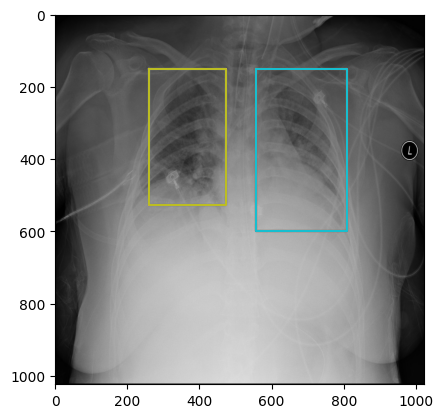

In [19]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

2 textfiles for training images and validation images.

In [20]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [21]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))


write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)

write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)


The # of train set: 5410, The # of validation set: 602


Test image and labels for YOLOv3

In [22]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [23]:
cd input

/home/vinnyfet/finalproj2/input


In [24]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

Sample test Image

In [25]:
pwd

'/home/vinnyfet/finalproj2/input'

In [26]:
cd ..

/home/vinnyfet/finalproj2


In [27]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [28]:
img_dir

'/home/vinnyfet/finalproj2/images'

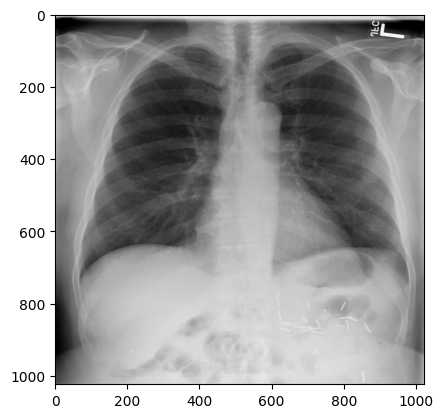

In [29]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))
#00436515-870c-4b36-a041-de91049b9ab4.jpg

Config files

In [30]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [31]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [32]:
cd ..

/home/vinnyfet/finalproj2


In [33]:
#cd darknet

In [34]:
!cat cfg/rsna.data

classes= 1
train  = /home/vinnyfet/finalproj2/metadata/tr_list.txt
valid  = /home/vinnyfet/finalproj2/metadata/val_list.txt
names  = /home/vinnyfet/finalproj2/cfg/rsna.names
backup = /home/vinnyfet/finalproj2/backup
    

In [35]:
!echo "pneumonia" > cfg/rsna.names

In [36]:
#!wget -q https://pjreddie.com/media/files/darknet53.conv.74

Train YOLOv3

In [38]:
#!sudo apt-get update

In [39]:
#!sudo apt-get install -y make

In [40]:
#!sudo apt install build-essential

In [41]:
pwd

'/home/vinnyfet/finalproj2'

In [42]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [43]:
#!sudo apt install libopencv-dev -y

In [44]:
#!export PATH=/usr/local/cuda/bin${PATH:+:${PATH}}

In [45]:
#!python -c "import cv2; print(cv2.__version__)


In [46]:
#!nvcc --version


In [47]:
#!sudo apt install libopencv-dev

In [48]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [49]:
#cd darknet

In [50]:
!make

make: Nothing to be done for 'all'.


darknet53.conv.74  (Download Pre-trained Model)

In [51]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-12-15 18:55:18--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.4’

darknet53.conv.74.4 100%[===================>] 154.96M  46.6MB/s    in 3.7s    

2022-12-15 18:55:22 (42.4 MB/s) - ‘darknet53.conv.74.4’ saved [162482580/162482580]



In [52]:
cd ..

/home/vinnyfet/finalproj2


In [53]:
pwd

'/home/vinnyfet/finalproj2'

In [54]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [55]:
%%time
!./darknet detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt 

subdivisions: Using default '1'
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11

In [60]:
pwd

'/home/vinnyfet/finalproj2/darknet'

Training loss plot

(0.0, 4.05)

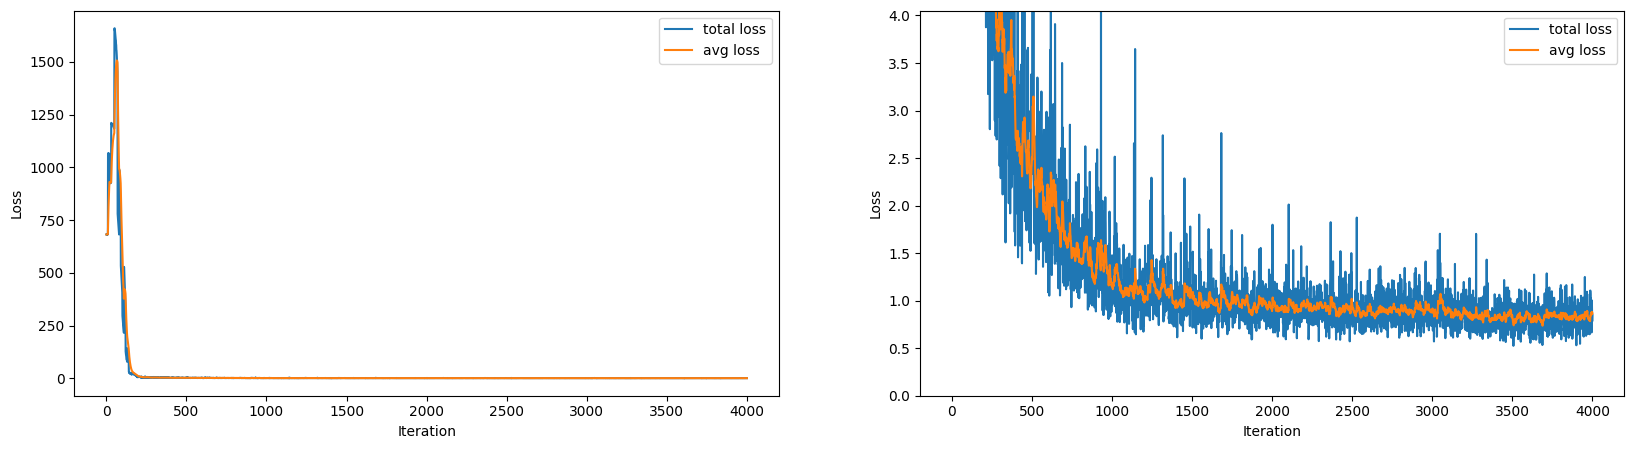

In [59]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(x=iters, y=total_losses, label="total loss")
sns.lineplot(x=iters, y=losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(x=iters, y=total_losses, label="total loss")
sns.lineplot(x=iters, y=losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

Trainined YOLOv3 for test images

In [59]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


In [64]:
pwd

'/home/vinnyfet/finalproj2'

In [67]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [65]:
!./darknet detector test cfg/rsna.data cfg/rsna_yolov3.cfg_test /home/vinnyfet/finalproj2/backup/rsna_yolov3_final.weights test.jpg -thresh 0.005

subdivisions: Using default '1'
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11

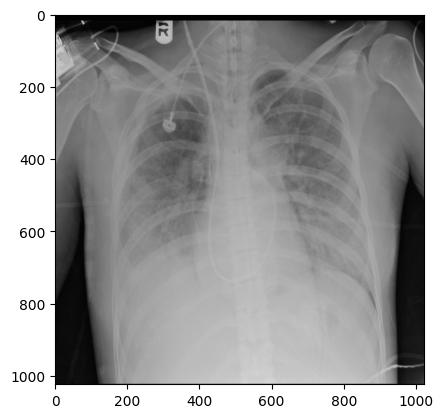

In [66]:
plt.imshow(cv2.imread("predictions.jpg"))